In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import cvxpy as cp
import mosek

In [5]:
gauss_x = np.arange(-4,4,0.0001)
gauss_y = np.zeros(len(gauss_x))
for i in range(len(gauss_x)):
    gauss_y[i] = norm.cdf(gauss_x[i])

def gauss_cdf(x):
    if np.abs(x) > 4:
        return(norm.cdf(x))
    else:
        return np.interp(x,gauss_x,gauss_y)

In [6]:
# Discrete Delta Hedging Strategy
def delta_hedging(S, K, r,mu, sigma, T,k0,k, num_steps):
    dt = T / num_steps
    d1 = (np.log(S / K) + (mu + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    cash = -K * np.exp(-r * T) * gauss_cdf(d2)

    # Delta hedging loop
    for i in range(1, num_steps):
        S_new = S * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.normal())
        d1_new = (np.log(S_new / K) + (r + 0.5 * sigma**2) * (T-i*dt)) / (sigma * np.sqrt(T-i*dt))   
        dd1 = (gauss_cdf(d1_new)-gauss_cdf(d1))
        cash_new = np.exp(r*dt) * cash - S_new * (dd1 + k*np.abs(dd1)) -k0
        S = S_new
        d1 = d1_new
        cash = cash_new
    S_pos = gauss_cdf(d1) * S
    Bond_pos = cash
    S_new = S * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.normal())
    
    
    return(np.abs(np.maximum(S_new-K,0)-S_pos-Bond_pos))
        

In [17]:
S0 = 1  # Initial stock price
K = 1   # Strike price
mu = 0.05  # Price drift
r = 0.01    # risk-free rate
sigma = 0.3  # Volatility
T = 1.0  # Time to maturity
k0 = 0.0002
k = 0.005
N = 8000
d_steps = np.arange(20,620,20)

In [13]:
hedge_data = np.loadtxt("hedge_data_8000.txt")

In [15]:


np.random.seed(3)

hedge_data = np.zeros((len(d_steps), N))
for i in range(len(d_steps)):
    print(i)
    for j in range(N):
        hedge_data[i,j] = delta_hedging(S0, K, r,mu, sigma, T,k0,k, d_steps[i])
    



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [23]:
np.savetxt('hedge_data_8000.txt', hedge_data)

In [336]:
hedge_data2 = np.copy(hedge_data)

In [343]:
hedge_data = np.concatenate((hedge_data,np.zeros((5,8000))))

array([[0.03287934, 0.01356713, 0.07047559, ..., 0.00332864, 0.0097165 ,
        0.02629482],
       [0.03067952, 0.02214334, 0.16058085, ..., 0.20912256, 0.02091973,
        0.04472972],
       [0.06608332, 0.01074675, 0.02003121, ..., 0.05233722, 0.02479319,
        0.02555379],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [268]:
a = 1/(2*(sigma*2)**2)
b = 2
alpha = 0.05
r = 0.3
X = -hedge_data[0]
para = [a,b,alpha,r,X]
x0 = np.array([-1,1,300])
p = np.zeros(len(X))+ 1/len(X)

In [19]:
def f_explog(x,a,b):   #### default: a=0.1, b=2
    if x > 0 :
        e = np.exp(1)
        ### constants calculations
        
        c1 = 1/(b**2*(a**2+a)*np.exp(a-1))
        c2 = 1 - np.exp(a)*(a*b+1)*c1
        c3 = -np.exp(a+1)*c1
        term = (x+e)*np.exp(a*np.log(x+e)**b) 
        return(c1*term + c2*x + c3)
    else:
        return(np.exp(x)-1)
    
def df_explog(x,a,b):
    if x > 0:
        e = np.exp(1)
        ### constants calculations
        
        c1 = 1/(b**2*(a**2+a)*np.exp(a-1))
        c2 = 1 - np.exp(a)*(a*b+1)*c1
        term = np.exp(a*(np.log(x+e))**b)*(a*b*(np.log(x+e))**(b-1)+1)
        return(c1*term + c2)
    else:
        return(np.exp(x))
    
    
def ddf_explog(x,a,b):
    if x > 0:
        e = np.exp(1)
        c1 = 1/(b**2*(a**2+a)*np.exp(a-1))
        
        term1 = a*b/(x+e)*np.exp(a*np.log(x+e)**b)
        term2 = (b-1)*np.log(x+e)**(b-2) + np.log(x+e)**(b-1) + a*b*np.log(x+e)**(2*b-2)
        return(c1*term1*term2)
    else:
        return(np.exp(x))
    
    
def CVaR(x,alpha):
    return np.maximum(1/alpha*x,0)

def dCVaR(x,alpha):
    if x > 0:
        return(1/alpha)
    else:
        return(0)

def KL(x):
    return np.exp(x)-1

    
    
def log_bar(x):
    if x>0:
        return(-np.log(x))
    else:
        return np.inf
    
def cvar_fast(alpha,x,f):
    n = len(f)
    order = np.argsort(x)
    x = np.sort(x)
    f = f[order]
    csum = np.cumsum(f)
    if csum[0] > alpha:
        return(x[0])
    else:
        k_max = np.max(np.where((csum < alpha)==True))
    Ex = np.sum(np.multiply(x[0:k_max+1],f[0:k_max+1]))
    last = (alpha - csum[k_max])*x[k_max+1]
    return(-1/alpha*(Ex+last))
    


In [21]:

def f_lexp(x,X,alpha,a,b,r):
    the1 = x[0]
    the2 = x[1]
    lbda = x[2]
    N = len(X)
    s1 = 0
    for i in range(N):
        arg = CVaR(the2-X[i],alpha)
        s1 = s1 + lbda * f_explog((arg+the1)/lbda,a,b)
    return(s1/N-the1-the2+lbda*r)

def grad_flexp(x,X,alpha,a,b,r):
    the1 = x[0]
    the2 = x[1]
    lbda = x[2]
    N = len(X)
    grad = np.zeros(3)
    s1 = 0
    s2 = 0
    s3 = 0
    for i in range(N):
        arg = CVaR(the2-X[i],alpha)
        s1 = s1 + df_explog((arg+the1)/lbda,a,b)
        s2 = s2 + df_explog((arg+the1)/lbda,a,b)* dCVaR(the2-X[i],alpha)
        s3 = s3 + f_explog((arg+the1)/lbda,a,b) - df_explog((arg+the1)/lbda,a,b) * ((arg+the1)/lbda)
    
    grad[0] = -1 + s1/N
    grad[1] = -1 + s2/N
    grad[2] = r + s3/N
    return(grad)

def f_constr(x):
    return -x[2]

def grad_f_constr(x):
    return np.array([0,0,-1])

In [7]:
def kl_cvar_ball(alpha,x,p,r):
    n = len(x)
    theta_1 = cp.Variable(1)
    theta_2 = cp.Variable(1)
    lbda = cp.Variable(1, nonneg = True)
    t = cp.Variable(n)
    w = cp.Variable(n)
    s = cp.Variable(n)
    constraints = []
    som = 0
    for i in range(n):
        #if wbln_factor(-x[i],0,np.sqrt(1.5)) >= 1e-5:
        constraints.append(theta_1 + cp.pos(1/alpha*(theta_2-x[i])) <= s[i])
        constraints.append((w[i] - lbda) <= t[i])   #2/(-x[i])*
        constraints.append(cp.kl_div(lbda,w[i])+lbda+s[i]-w[i]<= 0)
        som = som + t[i]*p[i]
    obj = cp.Minimize(-theta_1-theta_2+lbda*r+som)
    prob = cp.Problem(obj,constraints)
    prob.solve(solver = cp.MOSEK)
    return(prob.value, theta_1.value, theta_2.value, lbda.value)

In [23]:
def ellipsoid_constr_method(f_obj, f_constr, grad_f, grad_f_constr, x0, max_iter, r_e, para):
    n = len(x0)
    x = x0
    P = np.identity(n)*r_e
    a,b,alpha,r,X = para
    f_best = f_obj(x0,X,alpha,a,b,r)
    x_opt = x0
    
    for i in range(max_iter):
        # Calculate the subgradient at the current point.
        if x[2] >= 0:
            g = grad_f(x,X,alpha,a,b,r)
            n_g =np.sqrt((g.dot(P)).dot(g)) 
            g_n = g/n_g
            alfa = (f_obj(x,X,alpha,a,b,r)-f_best)/n_g
        else:
            g = grad_f_constr(x)
            #print('constr_g', (g.dot(P)).dot(g))
            n_g =np.sqrt((g.dot(P)).dot(g)) 
            g_n = g/n_g
            alfa = (f_constr(x))/n_g
        
        # normalize subgradient.
        alfa = 0
    
        # Update the ellipsoid parameters.
        U = g_n.dot(P)
        c1 = (n**2/(n**2-1)) * (1-alfa**2)
        c2 = (1+n*alfa)/((n+1)*(1+alfa))*2
        x = x - (1+n*alfa)/(n+1)* P.dot(g_n)
        P = c1 * (P - c2 * np.outer(U,U))
        #print('x', x)
            
        if f_obj(x,X,alpha,a,b,r) < f_best and x[2] >= 0:
            f_best = f_obj(x,X,alpha,a,b,r)
            x_opt = x
            x_grad = grad_f(x,X,alpha,a,b,r)
        #print('obj', f_best, 'sol', x_opt, np.max(P))
        
        if np.max(P) <= 1e-6:
            print('obj', f_best, 'sol', x_opt,'grad', x_grad,'P-norm', np.max(P))
            return(x_opt, f_best, x_grad)
    print('max iterations reached')

    return x_opt, f_best

In [9]:
a = 1/(2*(sigma*2)**2)
b = 2
alpha = 0.05
radius = 0.1

NameError: name 'sigma' is not defined

In [350]:
h_rob = np.concatenate((h_rob, np.zeros(5)))
h_e = np.concatenate((h_e, np.zeros(5)))

In [352]:
len(d_steps)

30

In [353]:
#h_rob = np.zeros(len(d_steps))
#h_e = np.zeros(len(d_steps))
for i in range(25,len(d_steps)):
    N_data = len(hedge_data[i])
    X = -hedge_data[i]
    para = [a,b,alpha,radius,X]
    x0 = np.array([-1,1,5])
    h_e[i] = cvar_fast(alpha,-hedge_data[i],np.zeros(N_data)+ 1/N_data)
    h_rob[i] = ellipsoid_constr_method(f_lexp, f_constr, grad_flexp, grad_f_constr, x0, 400, 1000, para)[1]

obj 0.20558888781412912 sol [-0.00464341 -0.1902422   0.1048668 ] grad [-7.24602246e-06  5.34669972e-05  1.13301263e-05] P-norm 6.989545305472034e-07
obj 0.2093194906807859 sol [-0.00431464 -0.19536076  0.09496496] grad [-0.00028052 -0.00259365  0.00028803] P-norm 7.927140012459783e-07
obj 0.21912224810562198 sol [-0.00599423 -0.19915263  0.13677966] grad [-1.39569883e-05  8.40619416e-04 -6.76041957e-05] P-norm 9.722116853816185e-07
obj 0.21940544910537266 sol [-0.00578883 -0.19983332  0.13469156] grad [-7.71245206e-05  2.69469038e-04 -5.54576237e-05] P-norm 6.920522399845354e-07
obj 0.22341982803827293 sol [-0.00439727 -0.20891737  0.09896043] grad [ 6.34308808e-05 -3.60942938e-04  4.84357736e-05] P-norm 7.883881602082682e-07


In [348]:
h_e1 = np.copy(h_e)
h_rob2 = np.copy(h_rob)

array([0.42102634, 0.26360869, 0.23145835, 0.18369331, 0.19327611,
       0.17617063, 0.1579568 , 0.16648116, 0.1672778 , 0.16978016,
       0.15665166, 0.1649026 , 0.16478069, 0.16310521, 0.17363373,
       0.16963774, 0.17112434, 0.17866887, 0.19206007])

In [362]:
print(np.argmin(h_e))
print(d_steps[4])
print(np.argmin(h_rob))
print(d_steps[10])

4
100
10
220


In [11]:
hedge_data = np.loadtxt('hedge_data.txt')
h_rob = np.loadtxt('h_rob.txt')
h_e = np.loadtxt('h_e.txt')
d_steps = np.loadtxt('d_steps.txt')

array([[0.03287934, 0.01356713, 0.07047559, ..., 0.00332864, 0.0097165 ,
        0.02629482],
       [0.03067952, 0.02214334, 0.16058085, ..., 0.20912256, 0.02091973,
        0.04472972],
       [0.06608332, 0.01074675, 0.02003121, ..., 0.05233722, 0.02479319,
        0.02555379],
       ...,
       [0.16441098, 0.14853773, 0.14995618, ..., 0.17101997, 0.12750869,
        0.16301947],
       [0.17140244, 0.146737  , 0.12033248, ..., 0.18378518, 0.19185372,
        0.17796759],
       [0.18529838, 0.1735106 , 0.1547978 , ..., 0.15348598, 0.16250841,
        0.15824003]])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


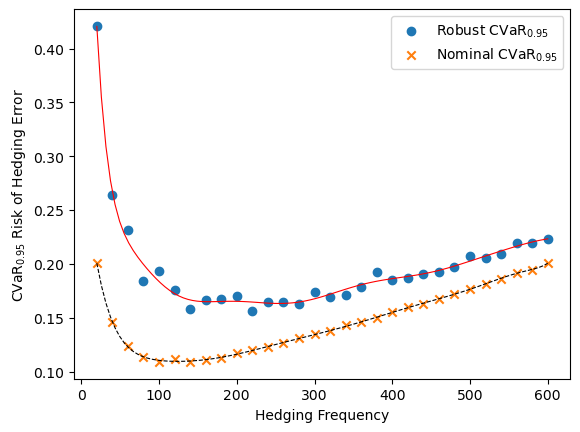

In [59]:

coefficients_rob = np.polyfit(d_steps, h_rob, 12)
coefficients_nom = np.polyfit(d_steps, h_e, 12)

# Generate points for the fitted curve
x_fit_rob = np.linspace(d_steps.min(), d_steps.max(), 100)
y_fit_rob = np.polyval(coefficients_rob, x_fit_rob)

x_fit_nom = np.linspace(d_steps.min(), d_steps.max(), 100)
y_fit_nom = np.polyval(coefficients_nom, x_fit_nom)

# Plot the original data
plt.scatter(d_steps, h_rob, label='Robust $\mathrm{CVaR}_{0.95}$')
plt.scatter(d_steps, h_e, label='Nominal $\mathrm{CVaR}_{0.95}$', marker = 'x')

# Plot the fitted curve
plt.plot(x_fit_rob, y_fit_rob, color='red',linewidth=0.8)
plt.plot(x_fit_nom, y_fit_nom, color='black',linewidth=0.8,linestyle = '--')

plt.xlabel('Hedging Frequency')
plt.ylabel('$\mathrm{CVaR}_{0.95}$ Risk of Hedging Error')
plt.legend()
plt.savefig('BlackScholes.eps', format = 'eps')


In [45]:
coefficients_h_rob

array([ 4.87781761e-30, -2.05044840e-26,  3.82350662e-23, -4.16449340e-20,
        2.93624282e-17, -1.40378274e-14,  4.63607799e-12, -1.05814162e-09,
        1.64500018e-07, -1.69059296e-05,  1.09435991e-03, -4.13167170e-02,
        9.21174027e-01])

In [254]:
ellipsoid_constr_method(f_lexp, f_constr, grad_flexp, grad_f_constr, x0, 400, 2000000, para)

x [  -2.26995205 -352.55079377  299.52730167]
obj 30.93983227055702 sol [ -1   1 300] 2249997.989006628
x [  0.77851879 -87.63674086 283.29386437]
obj 30.93983227055702 sol [ -1   1 300] 2531150.032050652
x [ -5.12167711 111.06783965 271.09884363]
obj 30.93983227055702 sol [ -1   1 300] 2847230.4752524537
x [-48.51836988   6.46531978 550.03652095]
obj 30.93983227055702 sol [ -1   1 300] 3186184.828166882
x [ -39.31182337 -131.37969631  397.42463413]
obj 30.93983227055702 sol [ -1   1 300] 3583695.0872002197
x [131.6763283  -37.30796258 474.22128536]
obj 30.93983227055702 sol [ -1   1 300] 3768524.4410104095
x [-310.35201287   17.78573391  531.7701938 ]
obj 30.93983227055702 sol [ -1   1 300] 3203115.0335353944
x [-325.93040669  -61.15690046  421.71663126]
obj 30.93983227055702 sol [ -1   1 300] 3494498.3330772608
x [ 57.61996398 -44.6987284  609.55119059]
obj 30.93983227055702 sol [ -1   1 300] 3613774.22962703
x [-137.13336222   10.13469698  606.02260221]
obj 30.93983227055702 sol [ -

obj 1.3405343822398337 sol [-3.13096998 -0.56566476 16.55229603] 28835.983330645795
x [ 7.9159667  -0.80643543 40.37772412]
obj 1.3405343822398337 sol [-3.13096998 -0.56566476 16.55229603] 30601.169674003577
x [-3.68354154 -0.41898912 43.56975289]
obj 1.3405343822398337 sol [-3.13096998 -0.56566476 16.55229603] 34334.614454030685
x [ 1.74436262 -0.13819442 12.48826158]
obj 0.6565737482429643 sol [ 1.74436262 -0.13819442 12.48826158] 29931.90934447979
x [ -5.55023816  -0.48219966 -15.93730159]
obj 0.6565737482429643 sol [ 1.74436262 -0.13819442 12.48826158] 26401.284236149466
constr_g 26401.284236149466
x [-7.10018725 -0.09513808 24.68387841]
obj 0.6565737482429643 sol [ 1.74436262 -0.13819442 12.48826158] 14850.72238283407
x [-3.34990492 -1.00745457 15.13071302]
obj 0.6565737482429643 sol [ 1.74436262 -0.13819442 12.48826158] 15885.695959713717
x [ 4.38409925 -0.80843233 10.82960846]
obj 0.6565737482429643 sol [ 1.74436262 -0.13819442 12.48826158] 17704.9124508637
x [-0.9138954  -0.434

x [ 0.01445663 -0.14078579  1.31567701]
obj 0.18384220071927074 sol [ 0.08284421 -0.1518954   0.7650771 ] 12.90275947292413
x [ 0.04204888 -0.1607635   0.46790589]
obj 0.1784201569720111 sol [ 0.04204888 -0.1607635   0.46790589] 8.047161543431885
x [-0.10686285 -0.13214349  0.33416352]
obj 0.1784201569720111 sol [ 0.04204888 -0.1607635   0.46790589] 8.892073528786112
x [-0.12471971 -0.15897018  0.63386648]
obj 0.1784201569720111 sol [ 0.04204888 -0.1607635   0.46790589] 9.195185938370525
x [ 0.13475911 -0.14360792  0.36819698]
obj 0.1784201569720111 sol [ 0.04204888 -0.1607635   0.46790589] 9.709361662737873
x [-0.05829379 -0.14140833  0.92083195]
obj 0.1784201569720111 sol [ 0.04204888 -0.1607635   0.46790589] 8.174383178852034
x [ 0.01954519 -0.16044645  0.26784418]
obj 0.171623990687289 sol [ 0.01954519 -0.16044645  0.26784418] 5.358643736211188
x [-0.09406358 -0.14327185  0.11400585]
obj 0.171623990687289 sol [ 0.01954519 -0.16044645  0.26784418] 5.815478140653433
x [-0.08541035 -0

x [-0.01506703 -0.14937199  0.2845757 ]
obj 0.16660471530990198 sol [-0.00774487 -0.14986599  0.2801409 ] 0.007615241150548973
x [-0.00910455 -0.14927023  0.28614357]
obj 0.16660471530990198 sol [-0.00774487 -0.14986599  0.2801409 ] 0.0085450224971183
x [-0.00911321 -0.15055722  0.26988383]
obj 0.16660471530990198 sol [-0.00774487 -0.14986599  0.2801409 ] 0.007233737958622904
x [-0.00732127 -0.1496594   0.28595698]
obj 0.16660471530990198 sol [-0.00774487 -0.14986599  0.2801409 ] 0.0058128390800779315
x [-0.01060623 -0.14968079  0.27337099]
obj 0.16660471530990198 sol [-0.00774487 -0.14986599  0.2801409 ] 0.005113780361982295
x [-0.00963881 -0.14977476  0.2858743 ]
obj 0.16660471530990198 sol [-0.00774487 -0.14986599  0.2801409 ] 0.004346008609237356
x [-0.00578621 -0.14968942  0.27433912]
obj 0.16660471530990198 sol [-0.00774487 -0.14986599  0.2801409 ] 0.003691716075597827
x [-0.00922405 -0.14965282  0.28292833]
obj 0.16660374358823454 sol [-0.00922405 -0.14965282  0.28292833] 0.0034

(array([-0.00869042, -0.1497083 ,  0.28159354]),
 0.16660294756637833,
 array([-1.12627248e-04, -7.86575858e-04,  5.90695178e-05]))

In [149]:
-0.0004344>=0

False

In [14]:
-1970.35-1978.42+3989.66

40.88999999999987

In [22]:
(58.955-58.36)*6

3.569999999999993

In [20]:
(377.75-372.85)-372.85*0.0002-277.75*0.0002

4.7698799999999775

In [21]:
372.85/58.36

6.388793694311173